**Import Packages**

In [2]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, backend, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

print("TensorFlow Version:", tf.__version__)
if tf.test.gpu_device_name():
    print("GPU Device: {}".format(tf.test.gpu_device_name()))

TensorFlow Version: 2.13.0
GPU Device: /device:GPU:0


2023-11-07 18:06:08.903981: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-11-07 18:06:08.904021: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-07 18:06:08.904032: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-07 18:06:08.904612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 18:06:08.905056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-11-07 18:06:08.909023: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built wit

**Load the data: Captcha Images**

In [3]:
# Path to the data directory
CaptchaImages = "./captcha_images_v2/"
if not os.path.isdir(CaptchaImages):     
    print('Downloading the Captcha images dataset ...')
    !curl -LO https://github.com/patrykwojnar/ComputerVision/raw/main/OCR/captcha_images_v2.zip
    !unzip -qq captcha_images_v2.zip
data_dir = Path(CaptchaImages)

print('Working directory:', data_dir)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  4119k      0  0:00:02  0:00:02 --:--:-- 7448k
Working directory: captcha_images_v2


In [4]:
# Get list of all the captcha images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)
image_height = set(
    tf.image.decode_png(tf.io.read_file(img_path)).shape[0] for img_path in images
)
image_width = set(
    tf.image.decode_png(tf.io.read_file(img_path)).shape[1] for img_path in images
)

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels), "\n")
print("Width of any captcha image:", next(iter(image_width)))
print("Height of any captcha image:", next(iter(image_height)))
print("Characters present: ", sorted(characters))
print("Number of unique characters: ", len(characters))
print("Maxium length of any captcha image: ", max_length)

2023-11-07 18:06:11.540661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-07 18:06:11.540686: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Number of images found:  1040
Number of labels found:  1040 

Width of any captcha image: 200
Height of any captcha image: 50
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
Number of unique characters:  19
Maxium length of any captcha image:  5


**Hyper-parameters**

In [5]:
# Desired image dimensions
img_width = 200
img_height = 50

# Number of passes of the entire training set the algorithm has completed
epochs = 100

# Dataset proportions
train = 0.95  # the best results for the captcha dataset
valid = (1 - train) / 2

# Batch Size
batch_size = 32

# Early Stopping
early_stopping_patience = 10
min_delta = 0.0001

**Preprocessing**

In [6]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=sorted(list(characters)), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    num_oov_indices=0,
    mask_token=None,
    invert=True,
)

/opt/homebrew/Caskroom/miniforge/base/envs/tf-m1/lib/python3.8/site-packages/numpy/core/numeric.py:2463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [7]:
def encode_single_sample(img_path, label):
    # 1. Read image
    image = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    image = tf.io.decode_png(image, channels=1)
    # 3. Convert to float32 in [0, 1] range
    image = tf.image.convert_image_dtype(image, tf.float32)
    # 4. Resize to the desired size
    image = tf.image.resize(image, [img_height, img_width])
    # 5. Transpose the image because we want the time dimension to correspond to the width of the image,
    #    i.e., shape = (img_weight,img_height,1).
    image = tf.transpose(image, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Ensure that the image has the expected shape
    image = tf.image.pad_to_bounding_box(image, 0, 0, img_width, img_height)
    # 8. Return a dict as our model is expecting two inputs
    return {"image": image, "label": label}

**Training, Validation and Test Sets**

In [8]:
# Splitting dataset into training, validation and test sets
def split_data(images, labels, train_size=0.8, validation_size=0.1, shuffle=True):
    # 1. Get the total amount of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.seed(42)
        np.random.shuffle(indices)
    # 3. Get the size of training and validation samples
    train_samples = int(size * train_size)
    validation_samples = int(size * validation_size)
    # 4. Split data into training, validation and test sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = (
        images[indices[train_samples : train_samples + validation_samples]],
        labels[indices[train_samples : train_samples + validation_samples]],
    )
    x_test, y_test = (
        images[indices[train_samples + validation_samples :]],
        labels[indices[train_samples + validation_samples :]],
    )

    return x_train, x_valid, x_test, y_train, y_valid, y_test


x_train, x_valid, x_test, y_train, y_valid, y_test = split_data(
    np.array(images), np.array(labels), train_size=train, validation_size=valid
)

print("Number of training set:", len(x_train))
print("Number of validation set:", len(x_valid))
print("Number of test set:", len(x_test))

Number of training set: 988
Number of validation set: 26
Number of test set: 26


**Create dataset objects**

In [9]:
# Create training, validation and test dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

**Visualize the data**

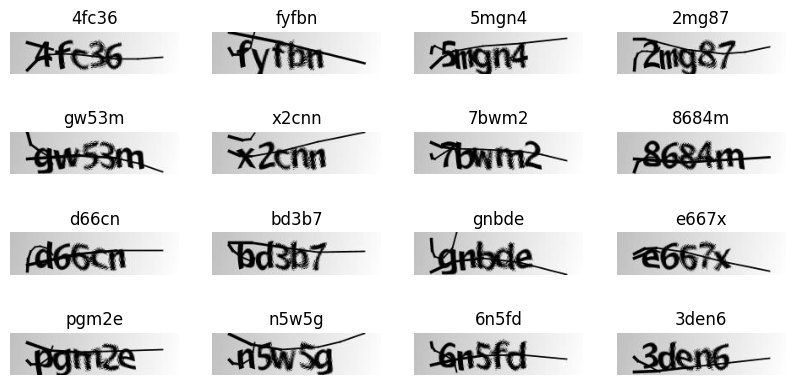

In [10]:
# Visualize the Training Dataset
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

**Convolutional Recurrent Neural Network (CRNN) Model**

In [11]:
# Build an endpoint layer for implementing CTC loss.
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name)
        self.loss_fn = backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

![Model architecture](model.jpg)

In [12]:
def Build_Model():
    # Inputs to the model
    input_tensor = layers.Input(
        (img_width, img_height, 1), dtype="float32", name="image"
    )
    labels = layers.Input(shape=(None,), dtype="float32", name="label")

    # First convolution block
    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv_1")(
        input_tensor
    )
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="Max-Pool_1")(x)

    # Second convolution block
    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="Conv_2")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name="Max-Pool_2")(x)

    # Third convolution block
    x = layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="Conv_3")(x)
    x = layers.BatchNormalization(name="BN_1")(x)

    # Fourth convolution block
    x = layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="Conv_4")(x)
    x = layers.MaxPooling2D(pool_size=(2, 1), strides=2, name="Max-Pool_3")(x)

    # Fifth convolution block
    x = layers.Conv2D(512, (2, 2), activation="relu", name="Conv_5")(x)

    # Reshape accordingly before passing the output to the RNN part of the model,
    # i.e., convert shape=(batch,feature_weight,feature_height,channel) to shape=(batch,feature_weight,channel*feature_height)
    conv_shape = x.get_shape()
    x = layers.Reshape(
        target_shape=(int(conv_shape[1]), int(conv_shape[2] * conv_shape[3])),
        name="Reshape",
    )(x)
    x = layers.Dense(64, activation="relu", name="Dense")(x)
    x = layers.Dropout(0.25, name="Dropout")(x)

    # Recurrent block
    x = layers.Bidirectional(
        layers.LSTM(256, return_sequences=True, dropout=0.25), name="LSTM_1"
    )(x)
    x = layers.Bidirectional(
        layers.LSTM(256, return_sequences=True, dropout=0.25), name="LSTM_2"
    )(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="Softmax")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTC_Loss")(labels, x)

    # Define the model
    model = Model(inputs=[input_tensor, labels], outputs=[output], name="CRNN_CTC")

    # Compile the model and return
    opt = optimizers.legacy.Adam()
    model.compile(optimizer=opt)

    return model


CRNN = Build_Model()
CRNN.summary()

Model: "CRNN_CTC"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv_1 (Conv2D)             (None, 200, 50, 64)          640       ['image[0][0]']               
                                                                                                  
 Max-Pool_1 (MaxPooling2D)   (None, 100, 25, 64)          0         ['Conv_1[0][0]']              
                                                                                                  
 Conv_2 (Conv2D)             (None, 100, 25, 128)         73856     ['Max-Pool_1[0][0]']          
                                                                                           

**Callbacks**

In [13]:
# Model Check Point
check_point = ModelCheckpoint(
    "my_CRNN.h5",  # Filepath
    monitor="val_loss",
    save_best_only=True,
    verbose=1,
    mode="auto",
    save_weights_only=False,
    save_freq="epoch",
)

In [14]:
# Add early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    min_delta=min_delta,
    patience=early_stopping_patience,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

**Training Model**

In [15]:
History = CRNN.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[check_point, early_stopping],
)

Epoch 1/100


2023-11-07 18:06:16.294418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.059672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.080927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.209016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.229140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.504315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:17.532851: I tensorflow/core/grappler/optimizers/cust

31/31 [==============================] - ETA: 0s - loss: 18.3011

2023-11-07 18:06:29.349769: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:29.673385: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:29.687805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:29.777478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:06:29.793067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 16.16163, saving model to my_CRNN.h5
31/31 [==============================] - 16s 398ms/step - loss: 18.3011 - val_loss: 16.1616
Epoch 2/100


/opt/homebrew/Caskroom/miniforge/base/envs/tf-m1/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - ETA: 0s - loss: 16.2378
Epoch 2: val_loss improved from 16.16163 to 16.11200, saving model to my_CRNN.h5
31/31 [==============================] - 11s 349ms/step - loss: 16.2378 - val_loss: 16.1120
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 16.1793
Epoch 3: val_loss improved from 16.11200 to 16.08354, saving model to my_CRNN.h5
31/31 [==============================] - 11s 348ms/step - loss: 16.1793 - val_loss: 16.0835
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 16.1176
Epoch 4: val_loss improved from 16.08354 to 16.05408, saving model to my_CRNN.h5
31/31 [==============================] - 11s 368ms/step - loss: 16.1176 - val_loss: 16.0541
Epoch 5/100
31/31 [==============================] - ETA: 0s - loss: 15.9115
Epoch 5: val_loss did not improve from 16.05408
31/31 [==============================] - 11s 352ms/step - loss: 15.9115 - val_loss: 16.7940
Epoch 6/100
31/31 [==========================

**Monitor Training**

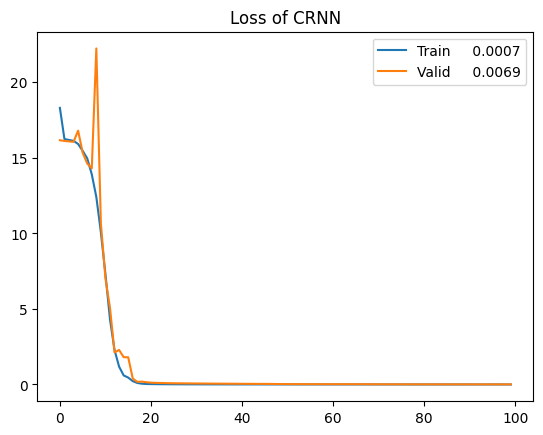

In [16]:
train_loss = History.history["loss"]
val_loss = History.history["val_loss"]
epochs_range = range(epochs)

plt.subplot()
plt.plot(
    range(len(train_loss)),
    train_loss,
    label="Train {:10.4f}".format(min(History.history["loss"])),
)
plt.plot(
    range(len(val_loss)),
    val_loss,
    label="Valid {:10.4f}".format(min(History.history["val_loss"])),
)
plt.legend(loc="upper right")
plt.title("Loss of CRNN")
plt.show()

**Inference**

In [17]:
# Get the prediction model by extracting layers till the output layer
prediction_model = Model(
    CRNN.get_layer(name="image").input,
    CRNN.get_layer(name="Softmax").output,
    name="Prediction",
)
prediction_model.summary()

Model: "Prediction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv_1 (Conv2D)             (None, 200, 50, 64)       640       
                                                                 
 Max-Pool_1 (MaxPooling2D)   (None, 100, 25, 64)       0         
                                                                 
 Conv_2 (Conv2D)             (None, 100, 25, 128)      73856     
                                                                 
 Max-Pool_2 (MaxPooling2D)   (None, 50, 12, 128)       0         
                                                                 
 Conv_3 (Conv2D)             (None, 50, 12, 256)       295168    
                                                                 
 BN_1 (BatchNormalization)   (None, 50, 12, 256)       1

In [18]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

**Results**

2023-11-07 18:24:22.923496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:24:23.282326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:24:23.297300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:24:23.419754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-07 18:24:23.434753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


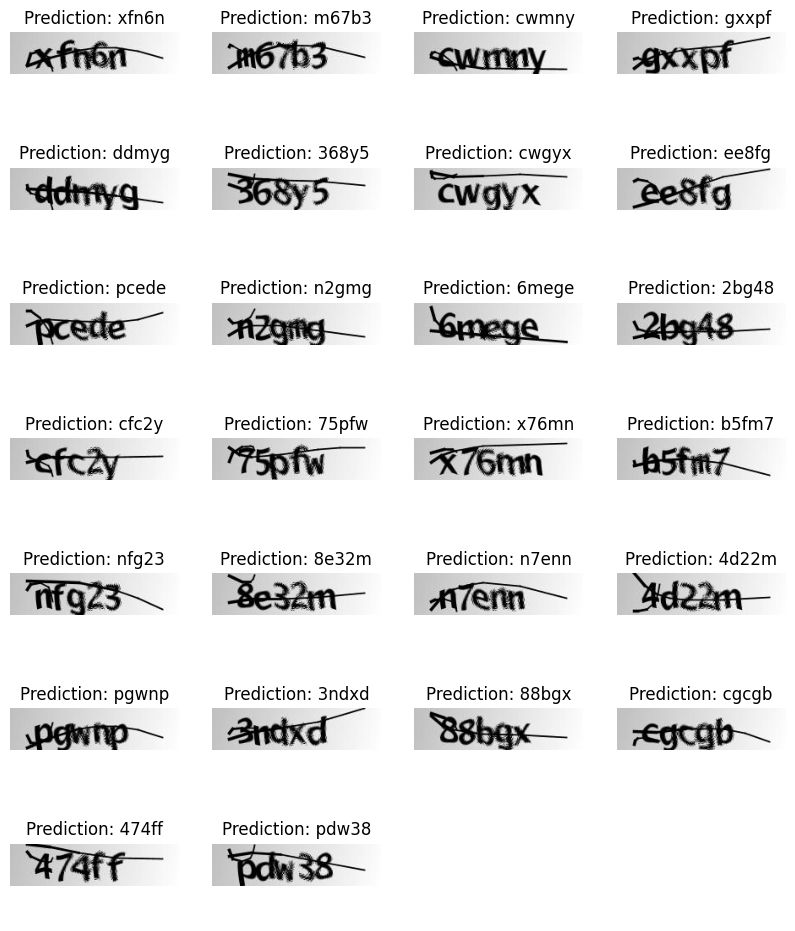

In [19]:
#  Check results on some test samples
for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    num_samples = len(pred_texts)
    cols = 4
    rows = (num_samples + cols - 1) // cols

    _, ax = plt.subplots(rows, cols, figsize=(10, 12))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    for i in range(len(pred_texts), rows * cols):
        ax[i // 4, i % 4].axis("off")
        ax[i // 4, i % 4].axis("off")
plt.show()